In [146]:
import os

from bs4 import BeautifulSoup
from io import StringIO
import html

import urllib.parse
import pandas as pd
import numpy as np
import re 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

# Data Wrangling Process

In [147]:
def full_text_transform(df, column, numeric_entity_pattern=r'#(\d+);'):
    """
    Cleans and transforms the specified column in the DataFrame:
    - Removes HTML tags.
    - Unescapes HTML entities.
    - Decodes URL-encoded characters.
    - Replaces numeric character references (e.g., #36; to $).
    - Removes common web-related tokens like 'http', 'www', 'href'.
    - Removes weekdays (full and abbreviated names).

    Args:
        df (pd.DataFrame): The DataFrame to process.
        column (str): The column name to transform.
        numeric_entity_pattern (str): Regex pattern for numeric entities.

    Returns:
        pd.DataFrame: The DataFrame with the transformed column.
    """
    def clean_and_replace(text):
        # Remove HTML tags
        soup = BeautifulSoup(StringIO(str(text)), features='html.parser')
        clean_text = soup.get_text()
        # Unescape HTML entities
        clean_text = html.unescape(clean_text)
        # Decode URL-encoded characters
        clean_text = urllib.parse.unquote(clean_text)
        # Replace numeric entities
        def replace_entity(match):
            return chr(int(match.group(1)))
        clean_text = re.sub(numeric_entity_pattern, replace_entity, clean_text)
        # Remove common web-related tokens and first-level domains
        clean_text = re.sub(r'\b(http|www|href|aspx|com|org|net|edu|gov|info|biz)\b', '', clean_text, flags=re.IGNORECASE)
        # Remove weekdays (full and abbreviations)
        clean_text = re.sub(
            r'\b(Monday|Mon|Tuesday|Tue|Tues|Wednesday|Wed|Thursday|Thu|Thurs|Friday|Fri|Saturday|Sat|Sunday|Sun)\b',
            '', clean_text, flags=re.IGNORECASE)
        # Remove extra whitespace
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()
        return clean_text

    df[column] = df[column].apply(clean_and_replace)
    return df


In [148]:
def clean_given_text(text):
    # Use BeautifulSoup to remove HTML tags, StringIO to avoid warning about URL format due to \ in text
    soup = BeautifulSoup(StringIO(str(text)), features='html.parser')
    clean_text = soup.get_text()

    #clean_text = replace_numeric_entities(clean_text)
    return clean_text


# trying to remove html character references and such - relevant for simpler encodings
def remove_character_references(df):
    df['Description'] = df['Description'].apply(clean_given_text)
    df['Description'] = df['Description'].apply(html.unescape)
    df['Description'] = df['Description'].apply(urllib.parse.unquote)

    df['Title'] = df['Title'].apply(clean_given_text)
    df['Title'] = df['Title'].apply(html.unescape)
    df['Title'] = df['Title'].apply(urllib.parse.unquote)


def replace_numeric_entities(text, pattern):
    # Replace all matches in the text with its char representation
    def replace_entity(match):
        # Convert the numeric part to an integer and then to the corresponding character
        return chr(int(match.group(1)))
    return re.sub(pattern, replace_entity, text)

def apply_transformation(df, pattern): 
    df['Description'] = df['Description'].apply(replace_numeric_entities, pattern=pattern)
    df['Title'] = df['Title'].apply(replace_numeric_entities, pattern=pattern)

In [149]:
def clean_title_based_on_source(df):
    """
    This function cleans the 'Title' column of a DataFrame by removing any occurrence of the source text,
    if it is enclosed in parentheses within the title.

    For each row:
      - It retrieves the 'Title' and 'source' values.
      - If 'source' is valid (not null and a string), it creates a regex pattern that escapes
        the source text enclosed in parentheses.
      - It then removes the matched pattern from the Title.
      - Finally, it normalizes extra whitespace in the title and updates the row.
    
    The updated DataFrame is returned after applying this cleaning function to every row.
    """
    def process_row(row):
        title = row.get('Title', '')
        src = row.get('source', '')
        #print(title)
        #print(src)
        
        # Check if the source is a valid string.
        if pd.notnull(src) and src.count(" ") == 0:
    
            # Build the regex pattern to match the source when it appears enclosed in parentheses.
            pattern = re.escape(f"({src})").replace("\\", "")
            #print("PAttern", pattern)
            # Remove the pattern from the title.
            new_title = title.replace(pattern, "")
            # Replace multiple whitespace with a single space and remove leading/trailing spaces.
            new_title = re.sub(r'\s+', ' ', new_title).strip()
            # Update the Title in the row.
            row.loc['Title'] = new_title
            #print(row['Title'])
        
        return row
    # Apply the process_row function to every row in the DataFrame.
    return df.apply(process_row, axis=1)

# Applying the function to news_df_test and printing the updated DataFrame.
#news_df_test = clean_title_based_on_source(news_df_test)
#print(news_df_test.head(10))

In [150]:
# Define a custom list of countries using a hardcoded list
custom_countries = [
    "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua and Barbuda",
    "Argentina", "Armenia", "Australia", "Austria", "Azerbaijan", "Bahamas", "Bahrain",
    "Bangladesh", "Barbados", "Belarus", "Belgium", "Belize", "Benin", "Bhutan",
    "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil", "Brunei", "Bulgaria",
    "Burkina Faso", "Burundi", "Côte d'Ivoire", "Cabo Verde", "Cambodia", "Cameroon",
    "Canada", "Central African Republic", "Chad", "Chile", "China", "Colombia",
    "Comoros", "Congo (Congo-Brazzaville)", "Costa Rica", "Croatia", "Cuba", "Cyprus",
    "Czechia (Czech Republic)", "Democratic Republic of the Congo", "Denmark", "Djibouti",
    "Dominica", "Dominican Republic", "Ecuador", "Egypt", "El Salvador",
    "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini (fmr. 'Swaziland')",
    "Ethiopia", "Fiji", "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany",
    "Ghana", "Greece", "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana",
    "Haiti", "Holy See", "Honduras", "Hungary", "Iceland", "India", "Indonesia",
    "Iran", "Iraq", "Ireland", "Israel", "Italy", "Jamaica", "Japan", "Jordan",
    "Kazakhstan", "Kenya", "Kiribati", "Kuwait", "Kyrgyzstan", "Laos", "Latvia",
    "Lebanon", "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania", "Luxembourg",
    "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali", "Malta", "Marshall Islands",
    "Mauritania", "Mauritius", "Mexico", "Micronesia", "Moldova", "Monaco", "Mongolia",
    "Montenegro", "Morocco", "Mozambique", "Myanmar (formerly Burma)", "Namibia",
    "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua", "Niger", "Nigeria",
    "North Korea", "North Macedonia", "Norway", "Oman", "Pakistan", "Palau",
    "Palestine State", "Panama", "Papua New Guinea", "Paraguay", "Peru", "Philippines",
    "Poland", "Portugal", "Qatar", "Romania", "Russia", "Rwanda",
    "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines", "Samoa",
    "San Marino", "Sao Tome and Principe", "Saudi Arabia", "Senegal", "Serbia",
    "Seychelles", "Sierra Leone", "Singapore", "Slovakia", "Slovenia", "Solomon Islands",
    "Somalia", "South Africa", "South Korea", "South Sudan", "Spain", "Sri Lanka",
    "Sudan", "Suriname", "Sweden", "Switzerland", "Syria", "Tajikistan", "Tanzania",
    "Thailand", "Timor-Leste", "Togo", "Tonga", "Trinidad and Tobago", "Tunisia",
    "Turkey", "Turkmenistan", "Tuvalu", "Uganda", "Ukraine",
    "United Arab Emirates", "United Kingdom", "United States of America", "Uruguay",
    "Uzbekistan", "Vanuatu", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"
]

def move_country_from_source_to_location(df, countries=custom_countries):
    """
    Searches for any country names within the 'source' column based on a given list
    and moves it to the 'location' column.

    Args:
        df (pd.DataFrame): DataFrame with at least a 'source' column and an optional 'location' column.
        countries (list): List of country names to search for (default is custom_countries).

    Returns:
        pd.DataFrame: Updated DataFrame with the country name moved from 'source' to 'location'.
    """
    def process_row(row):
        source_text = row.get('source')
        location_text = row.get('location')
        
        # Skip processing if source_text is not valid.
        if pd.isna(source_text) or not isinstance(source_text, str):
            return row
        
        new_source = source_text
        found_country = None
        
        # Check for any country present in the custom list.
        for country in countries:
            pattern = r'\b' + re.escape(country) + r'\b'
            match = re.search(pattern, new_source, flags=re.IGNORECASE)
            if match:
                found_country = match.group(0)
                new_source = re.sub(pattern, "", new_source, flags=re.IGNORECASE).strip()
                break  # Stop after the first match
        
        # Update source with cleaned value (if empty, set to None)
        row['source'] = new_source if new_source != "" else None
        
        # Update location with the found country if applicable.
        if found_country:
            if pd.isna(location_text) or location_text.strip() == "":
                row['location'] = found_country
            else:
                row['location'] = f"{location_text.strip()} {found_country}"
        return row

    return df.apply(process_row, axis=1)

# Apply the function to the test DataFrame and display updated head.
#news_df_test = move_country_from_source_to_location(news_df_test)
#print(news_df_test.head(10))

In [151]:
def restructure_source_location(df):
    """
    Process the 'source' column of a DataFrame to potentially split it into two parts:
    the actual source and a location extracted from source text based on various patterns.
    
    Steps:
      1. Checks if a 'source' column exists. If not, prints an error and returns the DataFrame unchanged.
      2. Ensures a 'location' column exists by creating it with default NaN values if missing.
      3. Defines several regex patterns to match common source formatting,
         including adaptations:
           - Abbreviation pattern: if the 'source' text starts with terms like "Calif." or "Flo.",
             then that word is moved to the 'location' column.
           - Dot pattern: if the 'source' begins with a word ending in a dot (excluding first-level domain names)
             then that word is moved to the 'location' column.
      4. Applies these patterns to each row of the 'source' column using the process_text helper.
      5. For entries where a location was extracted, the 'source' column is updated to the new source value,
         and the new information is stored in the 'location' column.
      6. Finally, the columns are reordered so that 'location' appears as the third column.
    
    Args:
        df (pd.DataFrame): The input DataFrame that must contain a 'source' column.
    
    Returns:
        pd.DataFrame: The updated DataFrame with potentially restructured 'source' and extracted 'location'.
    """
    
    if 'source' not in df.columns:
        print("Column 'source' does not exist in this DataFrame.")
        return df

    if 'location' not in df.columns:
        df['location'] = np.nan

    pattern_paren = r"^\s*([A-Z ]+)\s*\(([^)]+)\)"
    pattern_comma = r"^\s*([A-Z ]+),\s*(.+)$"

    def process_text(text):
        """
        Applies regex checks to extract potential new 'source' and 'location' values.
        
        Matching order:
          1. Website pattern: e.g., 'SPACE.com' splits domain from following text.
          2. Abbreviation pattern: if the source starts with terms like "Calif." or "Flo."
             then that term is moved to 'location'.
          3. Adapted Dot pattern: if the source starts with a word ending with a '.'
             that is not immediately followed by a common first-level-domain,
             then the initial word is moved to 'location'.
          4. Combo pattern: If text contains a comma before parentheses, uses the parenthesized text as source.
          5. Parentheses pattern: Extracts text inside parentheses after uppercase letters.
          6. Comma pattern: Alternate extraction with a comma.
          7. Two capitalized words: Uses them as the location.
          8. Fallback: Extracts a single all-caps word (more than three characters) as location.
        """
        if isinstance(text, str):
            # Website pattern
            pattern_website = r"^\s*([A-Za-z]+\.(?:com|org|net|edu|gov|info|biz))\s*(.*)$"
            match_website = re.match(pattern_website, text)
            if match_website:
                source_val = match_website.group(1).strip()
                location_val = match_website.group(2).strip() if match_website.group(2) else None
                return source_val, location_val

            # Abbreviation pattern
            pattern_abbrev = r'^\s*((?:Calif\.|Flo\.))\s+(.*)$'
            match_abbrev = re.match(pattern_abbrev, text)
            if match_abbrev:
                return match_abbrev.group(2).strip(), match_abbrev.group(1).strip()

            # Adapted Dot pattern:
            # Matches a leading word ending with a period that is NOT followed by a first-level-domain.
            match_dot = re.match(r'^\s*([\w\-]+\.)(?!\s*(?:com|org|net|edu|gov|info|biz)\b)(.*)$', text)
            if match_dot:
                # Here, the part ending with the dot is moved to 'location' 
                # while the rest of the text becomes the new source.
                return match_dot.group(2).strip(), match_dot.group(1).strip()

            # Combo pattern: text with parentheses at the end and a comma before.
            pattern_combo = r"^\s*(.+?)\s*\(([^()]+)\)\s*$"
            match_combo = re.match(pattern_combo, text)
            if match_combo:
                if "," in match_combo.group(1):
                    return match_combo.group(2).strip(), match_combo.group(1).strip()

            # Parentheses pattern.
            match = re.match(pattern_paren, text)
            if match:
                return match.group(2).strip(), match.group(1).strip()

            # Comma pattern.
            match2 = re.match(pattern_comma, text)
            if match2:
                return match2.group(2).strip(), match2.group(1).strip()

            # Look for two consecutive capitalized words.
            match_two = re.search(r'\b([A-Z]{2,})\s+([A-Z]{2,})\b', text)
            if match_two:
                location = f"{match_two.group(1)} {match_two.group(2)}"
                new_text = re.sub(re.escape(match_two.group(0)), '', text).strip()
                return new_text, location

            # Fallback: single all-caps word longer than three characters.
            candidates = re.findall(r'\b[A-Z]{4,}\b', text)
            if candidates:
                location = candidates[0]
                new_text = re.sub(r'\b' + re.escape(location) + r'\b', '', text).strip()
                return new_text, location
        return text, None

    processed = df["source"].apply(lambda x: process_text(x))
    new_sources = processed.apply(lambda t: t[0])
    locations = processed.apply(lambda t: t[1])

    mask = locations.notna()
    df.loc[mask, "source"] = new_sources[mask]
    df.loc[mask, "location"] = locations[mask]

    cols = df.columns.tolist()
    if "location" in cols:
        cols.remove("location")
        cols.insert(2, "location")
        df = df[cols]
        
    df["location"] = df["location"].astype('object')
    
    return df

#news_df_test = restructure_source_location(news_df_test)
#print(news_df_test.head(100))

In [152]:
def extract_source_from_description(df):
    """
    Extracts a source string from the 'Description' column of the DataFrame and updates the DataFrame accordingly.

    The function searches for separators in the beginning of the description as follows:
    - If a double hyphen (" -- ") is found within the first 35 characters, the part before it is
      considered the source and the rest is kept as the new description.
    - Otherwise, if a single hyphen (" - ") is found within the first 30 characters, the extraction
      is performed similarly.
      
    After processing, a new column 'source' is created (or updated) and the DataFrame columns are reordered
    so that 'source' appears as the second column.

    Args:
        df (pd.DataFrame): DataFrame containing a 'Description' column to process.

    Returns:
        pd.DataFrame: Updated DataFrame with the extracted 'source' and modified 'Description'.
    """
    def process_row(row):
        desc = row['Description']
        source_str = None  # Default value if no source is found.
        new_desc = desc    # By default, keep the original description

        # Check if a double hyphen (" -- ") is found in the first 35 characters.
        if ' -- ' in desc[:35]:
            parts = desc.split('--', 1)  # Split only at the first occurrence.
            source_str = parts[0].strip()  # Extract and remove extra whitespace from source.
            new_desc = parts[1].strip()    # The remainder becomes the new description.
        # If the double hyphen pattern wasn't found, check for a single hyphen (" - ")
        # in the first 30 characters and do a similar extraction.
        elif ' - ' in desc[:30]:
            parts = desc.split('-', 1)
            source_str = parts[0].strip()
            new_desc = parts[1].strip()

        # Update the row with the extracted source and the cleaned description.
        row['source'] = source_str
        row['Description'] = new_desc
        return row

    # Apply the processing function to every row in the DataFrame.
    df = df.apply(process_row, axis=1)

    # Reorder columns so that 'source' is the second column.
    cols = df.columns.tolist()
    if 'source' in cols:
        cols.remove('source')
        cols.insert(1, 'source')
        df = df[cols]

    return df

# Apply the function to the DataFrame and display the first 100 rows.
#news_df_test = extract_source_from_description(news_df_test)
#print(news_df_test.head(10))

# Importing and Cleaning Data

In [153]:
LABELS = {
    1: "World",
    2: "Sports", 
    3: "Business",
    4: "Science/Tech"
}

In [154]:
test_data_fp = '/home/manndo/Projects/NLP/Project2/nlp_project_2/data/test.csv'
train_data_fp = '/home/manndo/Projects/NLP/Project2/nlp_project_2/data/train.csv'


In [155]:
def get_cleaned_fp(fp):
    base, ext = os.path.splitext(fp)
    return f"{base}_cleaned.csv"

# Prepare file paths for cleaned data
train_cleaned_fp = get_cleaned_fp(train_data_fp)
test_cleaned_fp = get_cleaned_fp(test_data_fp)

df_dict = {}

# Check if cleaned files exist
if os.path.exists(train_cleaned_fp) and os.path.exists(test_cleaned_fp):
    print("Loading cleaned data files...")
    df_dict['train'] = pd.read_csv(train_cleaned_fp)
    df_dict['test'] = pd.read_csv(test_cleaned_fp)
else:
    print("Processing and saving cleaned data files...")
    df_dict['train'] = pd.read_csv(train_data_fp)
    df_dict['test'] = pd.read_csv(test_data_fp)
    df_dict['train']["Class Index"] = df_dict['train']["Class Index"].map(LABELS)
    df_dict['test']["Class Index"] = df_dict['test']["Class Index"].map(LABELS)
    for key in df_dict:
        df_dict[key] = full_text_transform(df_dict[key], "Description")
        df_dict[key] = extract_source_from_description(df_dict[key])
        df_dict[key] = clean_title_based_on_source(df_dict[key])
        df_dict[key] = restructure_source_location(df_dict[key])
        df_dict[key] = move_country_from_source_to_location(df_dict[key])
    df_dict['train'].to_csv(train_cleaned_fp, index=False)
    df_dict['test'].to_csv(test_cleaned_fp, index=False)

Loading cleaned data files...


In [156]:
train_df = df_dict['train']
test_df = df_dict['test']

print("\nCleaned Train DataFrame Shape:", train_df.shape)
print("Cleaned Train DataFrame:")
print(train_df.head().to_markdown())
print("\n" + "="*50 + "\n")
print("Cleaned Test DataFrame Shape:", test_df.shape)
print("\nCleaned Test DataFrame:")
print(test_df.head().to_markdown())



Cleaned Train DataFrame Shape: (120000, 5)
Cleaned Train DataFrame:
|    | Class Index   | source   |   location | Title                                                               | Description                                                                                                                                                                                                  |
|---:|:--------------|:---------|-----------:|:--------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | Business      | Reuters  |        nan | Wall St. Bears Claw Back Into the Black                             | Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.                                                                                  

In [157]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Prepare data
X_all = vectorizer.transform(train_df['Description'])
y_all = train_df['Class Index']
le = LabelEncoder()
y_all_enc = le.fit_transform(y_all)

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all_enc, test_size=0.2, random_state=42, stratify=y_all_enc)

# Fit NMF on training data
nmf_model = NMF(n_components=4, random_state=42)
W_train = nmf_model.fit_transform(X_train)
W_val = nmf_model.transform(X_val)

# Train classifier on NMF features
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(W_train, y_train)

# Predict on validation set
y_pred = clf.predict(W_val)
print(classification_report(y_val, y_pred, target_names=le.classes_))

# Predict topics for test_df
X_test = vectorizer.transform(test_df['Description'])
W_test = nmf_model.transform(X_test)
test_pred = clf.predict(W_test)
test_df['Predicted Class Index'] = le.inverse_transform(test_pred)
test_df[['Title', 'Predicted Class Index']].head()

              precision    recall  f1-score   support

    Business       0.78      0.48      0.60      6000
Science/Tech       0.32      0.19      0.24      6000
      Sports       0.49      0.80      0.61      6000
       World       0.67      0.79      0.72      6000

    accuracy                           0.56     24000
   macro avg       0.57      0.56      0.54     24000
weighted avg       0.57      0.56      0.54     24000



,Title,Predicted Class Index
0,Fears for T N pension after talks,World
1,The Race is On: Second Private Team Sets Launc...,Sports
2,Ky. Company Wins Grant to Study Peptides,Sports
3,Prediction Unit Helps Forecast Wildfires,Science/Tech
4,Calif. Aims to Limit Farm-Related Smog,World



NMF n_components=8
  Logistic Regression: Accuracy=0.6968
  Random Forest: Accuracy=0.7677
  Linear SVC: Accuracy=0.7058
  Naive Bayes: Accuracy=0.6538

NMF n_components=16
  Logistic Regression: Accuracy=0.7490
  Random Forest: Accuracy=0.8083
  Linear SVC: Accuracy=0.7538
  Naive Bayes: Accuracy=0.6733

NMF n_components=32
  Logistic Regression: Accuracy=0.7525
  Random Forest: Accuracy=0.8257
  Linear SVC: Accuracy=0.7596
  Naive Bayes: Accuracy=0.6979

NMF n_components=64
  Logistic Regression: Accuracy=0.7458
  Random Forest: Accuracy=0.8306
  Linear SVC: Accuracy=0.7735
  Naive Bayes: Accuracy=0.7166

NMF n_components=128
  Logistic Regression: Accuracy=0.6665
  Random Forest: Accuracy=0.8376
  Linear SVC: Accuracy=0.7411
  Naive Bayes: Accuracy=0.7441


,n_components,Classifier,Accuracy
0,8,Logistic Regression,0.696833
1,8,Random Forest,0.767667
2,8,Linear SVC,0.705792
3,8,Naive Bayes,0.653833
4,16,Logistic Regression,0.749042
5,16,Random Forest,0.808333
6,16,Linear SVC,0.753750
7,16,Naive Bayes,0.673250
8,32,Logistic Regression,0.752458
9,32,Random Forest,0.825667


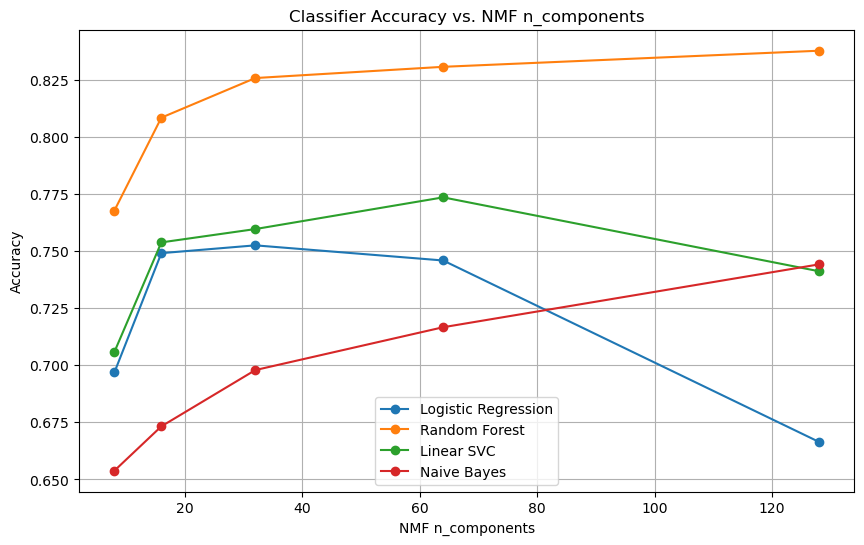

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import pandas as pd

# Prepare data
X_all = vectorizer.transform(train_df['Description'])
y_all = train_df['Class Index']
le = LabelEncoder()
y_all_enc = le.fit_transform(y_all)

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all_enc, test_size=0.2, random_state=42, stratify=y_all_enc)

# Try different classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Linear SVC": LinearSVC(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB()
}

results = []

for n in [8, 16, 32, 64, 128]:
    nmf_model = NMF(n_components=n, random_state=42, max_iter=500)
    W_train = nmf_model.fit_transform(X_train)
    W_val = nmf_model.transform(X_val)
    print(f"\nNMF n_components={n}")
    for name, clf in classifiers.items():
        # GaussianNB requires dense input
        if name == "Naive Bayes":
            clf.fit(W_train, y_train)
            y_pred = clf.predict(W_val)
        else:
            clf.fit(W_train, y_train)
            y_pred = clf.predict(W_val)
        acc = accuracy_score(y_val, y_pred)
        print(f"  {name}: Accuracy={acc:.4f}")
        results.append({"n_components": n, "Classifier": name, "Accuracy": acc})

# Show all results as a DataFrame
results_df = pd.DataFrame(results)
display(results_df)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for clf_name in results_df['Classifier'].unique():
    subset = results_df[results_df['Classifier'] == clf_name]
    plt.plot(subset['n_components'], subset['Accuracy'], marker='o', label=clf_name)
plt.xlabel('NMF n_components')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy vs. NMF n_components')
plt.legend()
plt.grid(True)
plt.show()


[INFO] Vectorizing with max_features=500, LSA n_components=50
  [INFO] Training Logistic Regression ... done. Accuracy=0.7847
  [INFO] Training Random Forest ... done. Accuracy=0.7987
  [INFO] Training Linear SVC ... done. Accuracy=0.7824
  [INFO] Training Naive Bayes ... done. Accuracy=0.6849

[INFO] Vectorizing with max_features=500, LSA n_components=100
  [INFO] Training Logistic Regression ... done. Accuracy=0.7935
  [INFO] Training Random Forest ... done. Accuracy=0.8018
  [INFO] Training Linear SVC ... done. Accuracy=0.7933
  [INFO] Training Naive Bayes ... done. Accuracy=0.6785

[INFO] Vectorizing with max_features=500, LSA n_components=200
  [INFO] Training Logistic Regression ... done. Accuracy=0.8064
  [INFO] Training Random Forest ... done. Accuracy=0.8010
  [INFO] Training Linear SVC ... done. Accuracy=0.8059
  [INFO] Training Naive Bayes ... done. Accuracy=0.7004

[INFO] Vectorizing with max_features=1000, LSA n_components=50
  [INFO] Training Logistic Regression ... done

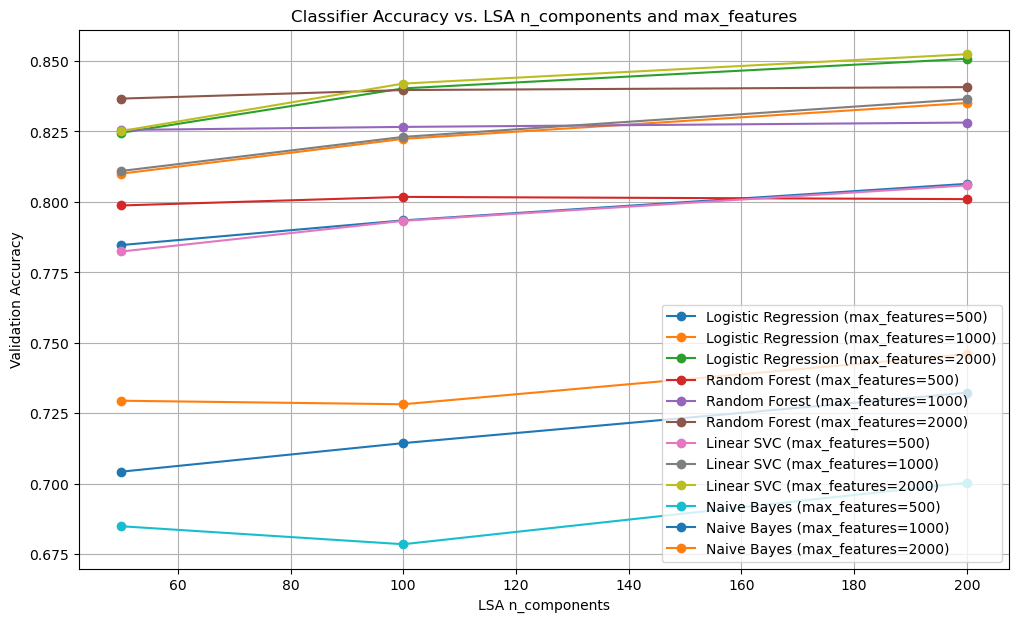

In [160]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

# Hyperparameter grids
max_features_list = [500, 1000, 2000]
n_components_list = [50, 100, 200]
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Linear SVC": LinearSVC(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB()
}

results = []

for max_features in max_features_list:
    for n_components in n_components_list:
        print(f"\n[INFO] Vectorizing with max_features={max_features}, LSA n_components={n_components}")
        # Vectorize
        vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features)
        X = vectorizer.fit_transform(train_df['Description'])
        # LSA
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        X_reduced = svd.fit_transform(X)
        # Split
        X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)
        for name, clf in classifiers.items():
            print(f"  [INFO] Training {name} ...", end="")
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            acc = (y_pred == y_val).mean()
            print(f" done. Accuracy={acc:.4f}")
            results.append({
                "max_features": max_features,
                "n_components": n_components,
                "Classifier": name,
                "Accuracy": acc
            })

# Results DataFrame
results_df = pd.DataFrame(results)

# Plot
plt.figure(figsize=(12, 7))
for clf_name in results_df['Classifier'].unique():
    subset = results_df[results_df['Classifier'] == clf_name]
    for mf in max_features_list:
        mf_subset = subset[subset['max_features'] == mf]
        plt.plot(
            mf_subset['n_components'],
            mf_subset['Accuracy'],
            marker='o',
            label=f"{clf_name} (max_features={mf})"
        )
plt.xlabel('LSA n_components')
plt.ylabel('Validation Accuracy')
plt.title('Classifier Accuracy vs. LSA n_components and max_features')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import pandas as pd

# 1. Prepare data
X_text = train_df['Description']
y = train_df['Class Index']

# 2. Vectorize text
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(X_text).toarray()  # PCA requires dense array

# 3. Apply PCA
n_topics = 4  # AG News has 4 classes/topics
pca = PCA(n_components=n_topics, random_state=42)
X_pca = pca.fit_transform(X)



Topic 1: quot president said minister prime yesterday called says iraq told
Topic 2: fullquote stocks reuters ticker investor target quickinfo quot said company
Topic 3: said president minister iraq people government killed prime officials iraqi
Topic 4: new company software microsoft internet corp service computer search york


In [164]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

# 1. Prepare data
X_text = train_df['Description']
y = train_df['Class Index']

# 2. Vectorize text
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(X_text).toarray()  # PCA requires dense array

# 3. Apply PCA
n_topics = 4  # AG News has 4 classes/topics
pca = PCA(n_components=n_topics, random_state=42)
X_pca = pca.fit_transform(X)

# 4. Inspect top words for each topic (principal component)
feature_names = vectorizer.get_feature_names_out()
for i, component in enumerate(pca.components_):
    top_indices = component.argsort()[-10:][::-1]
    top_words = [feature_names[idx] for idx in top_indices]
    print(f"Topic {i+1}: {' '.join(top_words)}")

# 4. Train/test split
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)
# 5. Train and evaluate different classifiers

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Linear SVC": LinearSVC(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB()
}

for name, clf in classifiers.items():
    print(f"\nClassifier: {name}")
    if name == "Naive Bayes":
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
    print(classification_report(y_val, y_pred))

Topic 1: quot president said minister prime yesterday called says iraq told
Topic 2: fullquote stocks reuters ticker investor target quickinfo quot said company
Topic 3: said president minister iraq people government killed prime officials iraqi
Topic 4: new company software microsoft internet corp service computer search york

Classifier: Logistic Regression
              precision    recall  f1-score   support

    Business       0.75      0.63      0.68      6000
Science/Tech       0.65      0.67      0.66      6000
      Sports       0.82      0.86      0.84      6000
       World       0.75      0.80      0.77      6000

    accuracy                           0.74     24000
   macro avg       0.74      0.74      0.74     24000
weighted avg       0.74      0.74      0.74     24000


Classifier: Random Forest
              precision    recall  f1-score   support

    Business       0.73      0.70      0.71      6000
Science/Tech       0.69      0.69      0.69      6000
      Sports 

Starting Bag-of-Words experiments...
  [BoW] Vectorizing: max_features=500, ngram_range=(1, 1)
    Training Logistic Regression ... done. Accuracy=0.8153
    Training Random Forest ... done. Accuracy=0.8207
    Training Linear SVC ... done. Accuracy=0.8187
    Training Multinomial NB ... done. Accuracy=0.8033
  [BoW] Vectorizing: max_features=500, ngram_range=(1, 2)
    Training Logistic Regression ... done. Accuracy=0.8132
    Training Random Forest ... done. Accuracy=0.8170
    Training Linear SVC ... done. Accuracy=0.8150
    Training Multinomial NB ... done. Accuracy=0.7984
  [BoW] Vectorizing: max_features=1000, ngram_range=(1, 1)
    Training Logistic Regression ... done. Accuracy=0.8465
    Training Random Forest ... done. Accuracy=0.8474
    Training Linear SVC ... done. Accuracy=0.8501
    Training Multinomial NB ... done. Accuracy=0.8391
  [BoW] Vectorizing: max_features=1000, ngram_range=(1, 2)
    Training Logistic Regression ... done. Accuracy=0.8450
    Training Random Fo

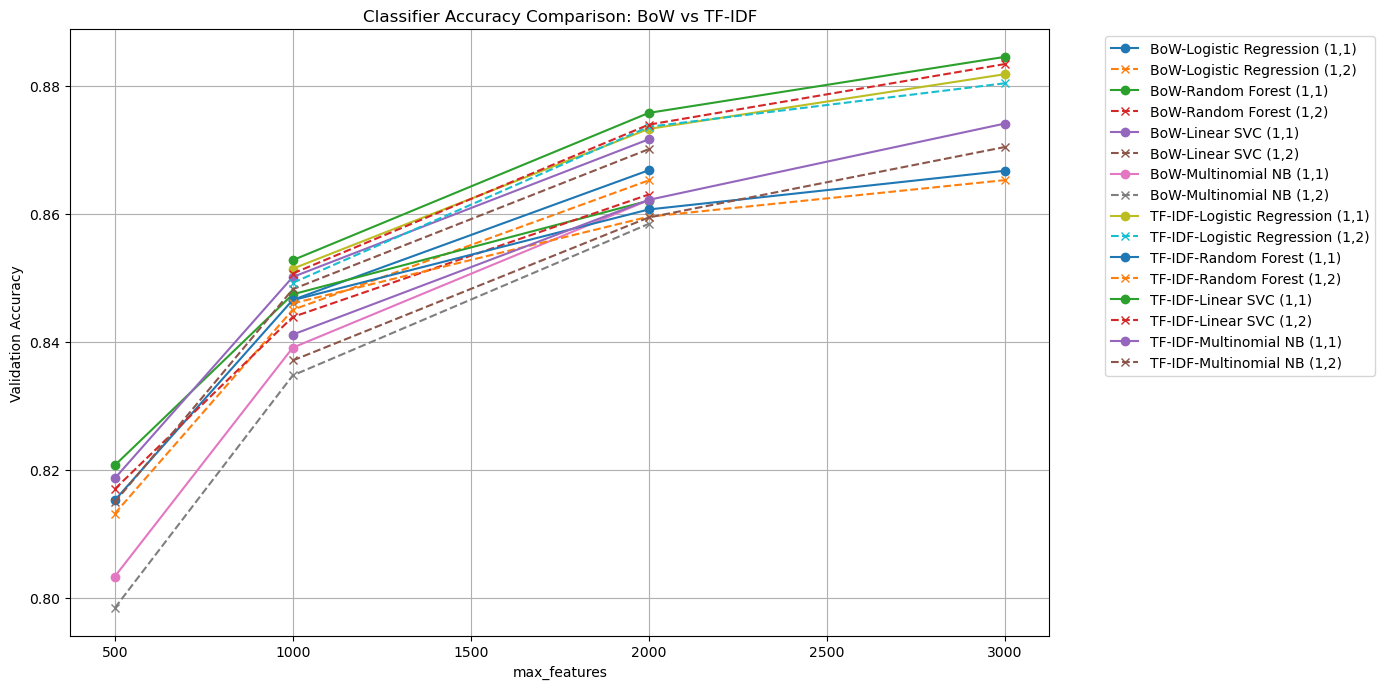

In [167]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

X_text = train_df['Description']
y = train_df['Class Index']

# Hyperparameters for each method
bow_params = {'max_features': [500, 1000, 2000], 'ngram_range': [(1,1), (1,2)]}
tfidf_params = {'max_features': [1000, 2000, 3000], 'ngram_range': [(1,1), (1,2)]}

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Linear SVC": LinearSVC(max_iter=1000, random_state=42),
    "Multinomial NB": MultinomialNB()
}

results = []

# Bag-of-Words
print("Starting Bag-of-Words experiments...")
for max_feat in bow_params['max_features']:
    for ngram in bow_params['ngram_range']:
        print(f"  [BoW] Vectorizing: max_features={max_feat}, ngram_range={ngram}")
        bow_vectorizer = CountVectorizer(stop_words='english', max_features=max_feat, ngram_range=ngram)
        X_bow = bow_vectorizer.fit_transform(X_text)
        X_train, X_val, y_train, y_val = train_test_split(X_bow, y, test_size=0.2, random_state=42, stratify=y)
        for name, clf in classifiers.items():
            print(f"    Training {name} ...", end="")
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            acc = accuracy_score(y_val, y_pred)
            print(f" done. Accuracy={acc:.4f}")
            results.append({
                "Method": "BoW",
                "max_features": max_feat,
                "ngram_range": str(ngram),
                "Classifier": name,
                "Accuracy": acc
            })

# TF-IDF
print("Starting TF-IDF experiments...")
for max_feat in tfidf_params['max_features']:
    for ngram in tfidf_params['ngram_range']:
        print(f"  [TF-IDF] Vectorizing: max_features={max_feat}, ngram_range={ngram}")
        tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=max_feat, ngram_range=ngram)
        X_tfidf = tfidf_vectorizer.fit_transform(X_text)
        X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)
        for name, clf in classifiers.items():
            print(f"    Training {name} ...", end="")
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            acc = accuracy_score(y_val, y_pred)
            print(f" done. Accuracy={acc:.4f}")
            results.append({
                "Method": "TF-IDF",
                "max_features": max_feat,
                "ngram_range": str(ngram),
                "Classifier": name,
                "Accuracy": acc
            })

results_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(14, 7))
for method in results_df['Method'].unique():
    for clf_name in results_df['Classifier'].unique():
        subset = results_df[(results_df['Method'] == method) & (results_df['Classifier'] == clf_name) & (results_df['ngram_range'] == "(1, 1)")]
        plt.plot(subset['max_features'], subset['Accuracy'], marker='o', label=f"{method}-{clf_name} (1,1)")
        # Optionally plot bigrams as dashed lines
        subset2 = results_df[(results_df['Method'] == method) & (results_df['Classifier'] == clf_name) & (results_df['ngram_range'] == "(1, 2)")]
        plt.plot(subset2['max_features'], subset2['Accuracy'], marker='x', linestyle='--', label=f"{method}-{clf_name} (1,2)")

plt.xlabel('max_features')
plt.ylabel('Validation Accuracy')
plt.title('Classifier Accuracy Comparison: BoW vs TF-IDF')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()